# 六分类， 判断 a 的位置，6为 a 不存在

第1轮平均loss:1.389136
correct: 185, rate: 0.925000
第2轮平均loss:1.201300
correct: 200, rate: 1.000000
第3轮平均loss:1.171876
correct: 200, rate: 1.000000
第4轮平均loss:1.167296
correct: 200, rate: 1.000000
第5轮平均loss:1.166579
correct: 200, rate: 1.000000
第6轮平均loss:1.166078
correct: 200, rate: 1.000000
第7轮平均loss:1.165806
correct: 200, rate: 1.000000
第8轮平均loss:1.165689
correct: 200, rate: 1.000000
第9轮平均loss:1.165615
correct: 200, rate: 1.000000
第10轮平均loss:1.165550
correct: 200, rate: 1.000000
第11轮平均loss:1.165521
correct: 200, rate: 1.000000
第12轮平均loss:1.165498
correct: 200, rate: 1.000000
第13轮平均loss:1.165481
correct: 200, rate: 1.000000
第14轮平均loss:1.165467
correct: 200, rate: 1.000000
第15轮平均loss:1.165456
correct: 200, rate: 1.000000
第16轮平均loss:1.165449
correct: 200, rate: 1.000000
第17轮平均loss:1.165475
correct: 200, rate: 1.000000
第18轮平均loss:1.165441
correct: 200, rate: 1.000000
第19轮平均loss:1.165436
correct: 200, rate: 1.000000
第20轮平均loss:1.165432
correct: 200, rate: 1.000000


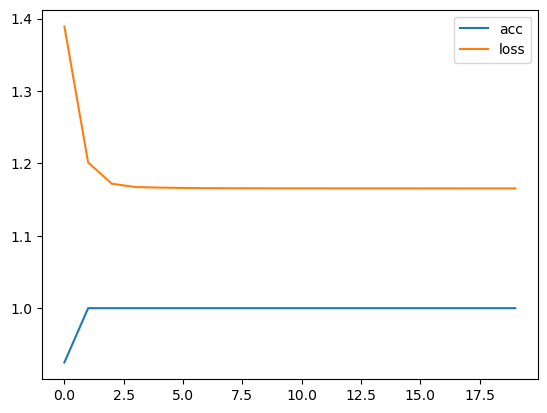

input: fnvfee, pred: 6, rate: 0.999997
input: wzsdfg, pred: 6, rate: 0.999996
input: rqwdeg, pred: 6, rate: 0.999996
input: nakwww, pred: 1, rate: 0.999954


In [2]:
import torch
import torch.nn as nn
import numpy as np
import random
import json
import matplotlib.pyplot as plt

class TorchModel(nn.Module):
    def __init__(self, vector_dim, sentence_length, vocab):
        super(TorchModel, self).__init__()
        self.embedding = nn.Embedding(len(vocab), vector_dim)
        # 将序列的每个词向量输入到 rnn 中，vector_dim 向量的维度
        self.rnn = nn.RNN(vector_dim, vector_dim, batch_first=True)
        # 将 rnn 的输出映射到维度为sentence_length + 1的向量，表示字母 a 的分类概率，多加一维，表示 a 不存在的情况
        self.classify = nn.Linear(vector_dim, sentence_length + 1)
        # softmax 归一化处理，得到概率分布
        self.activation = nn.Softmax(dim=1) 
        # 损失函数使用 crossEntropy， 适用于多分类任务
        self.loss = nn.CrossEntropyLoss()

    #当输入真实标签，返回loss值；无真实标签，返回预测值
    def forward(self, x, y=None):
        # x => (batch_size, sequence_length) => (batch_size, sequence_length, vector_dim)
        x = self.embedding(x)
        # rnn： => (batch_size, sequence_length, vector_dim)
        # rnn 的输出： 输出序列和隐藏状态
        x, _ = self.rnn(x)
        
        # 输入: (batch_size, vector_dim)
        # classify 输出： (batch_size, sentence_length+1)
        # rnn batch_first 表示 张量 x 的输出维度是： (batch_size, sequence_length, vector_dim)
        # 选择最后一个时间步
        # ：选择所有样本， -1 选择最后一个时间步， ：选择所有特征维度
        x = self.classify(x[:, -1, :])
        # 输出: (batch_size, sentence_length+1)
        y_pred = self.activation(x)
        if y is not None:
            return self.loss(y_pred, y)   #预测值和真实值计算损失
        else:
            return y_pred                 #输出预测结果
        
        
def build_vocab():
    chars = "abcdefghijklmnopqrstuvwxyz"  #字符集
    vocab = {"pad":0}
    for index, char in enumerate(chars):
        vocab[char] = index+1   #每个字对应一个序号
    # “unk” =》 unknown
    vocab['unk'] = len(vocab) #26
    return vocab

def build_sample(vocab, sentence_length):
    # for _ in range(sentence_length) 循环sentence_length 次，但内部不需要迭代变量的值
    # vocab.keys() 返回 vocab 里所有的键
    # list（） 转为列表
    # random.choice 随机取一个值
    x = [random.choice(list(vocab.keys())) for _ in range(sentence_length)]
    if 'a' in x:
        y = x.index('a')
    else:
        # nn.CrossEntropyLoss() 不支持负数作为目标值。
        # 我们可以将缺失的目标值设置为一个大于等于 sentence_length 的值，以确保它不会与真实标签冲突。
        y = sentence_length
    x = [vocab.get(word, vocab['unk']) for word in x]
    return x, y

def build_dataset(sample_length, vocab, sentence_length):
    dataset_x = []
    dataset_y = []
    for i in range(sample_length):
        x, y = build_sample(vocab, sentence_length)
        dataset_x.append(x)
        # 注意这里
        dataset_y.append(y)
    return torch.LongTensor(dataset_x), torch.LongTensor(dataset_y)

def build_model(vocab, char_dim, sentence_length):
    model = TorchModel(char_dim, sentence_length, vocab)
    return model

def evaluate(model, vocab, sample_length):
    model.eval()
    x, y = build_dataset(200, vocab, sample_length)
    correct, wrong = 0, 0
    with torch.no_grad():
        # y_pred: (batch_size, sentence_size+1)
        y_pred = model(x)
        # 在 y_pred 张量的第一个维度取最大值
        # 第一个返回值，包含每个样本中的最大值，具体维度（batch_size, ）
        # 第二个返回值，每个样本中最大值的索引, 具体维度 (batch_size, )
        _, predicted = torch.max(y_pred, dim=1)
        # (predicted == y).sum() => Tensor(120)
        # 对布尔张量进行求和操作，将 True 的数量加起来，得到一个整数张量
        # .item() 转换为 python 标量
        correct = (predicted == y).sum().item()
        wrong = (predicted != y).sum().item()
    accuracy = correct / (correct + wrong)
    print("correct: %d, rate: %f" % (correct, accuracy))
    return accuracy

def main():
    epoch_num = 20
    batch_size = 100
    train_sample = 50000
    char_dim = 20
    sentence_length = 6
    lr = 0.001
    vocab = build_vocab()
    model = build_model(vocab, char_dim, sentence_length)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    log = []
    for epoch in range(epoch_num):
        model.train()
        watch_loss = []
        for batch in range(int(train_sample/batch_size)):
            x, y = build_dataset(batch_size, vocab, sentence_length)
            optim.zero_grad()
            loss = model(x, y)
            loss.backward()
            optim.step()
            watch_loss.append(loss.item())
        print("=========\n第%d轮平均loss:%f" % (epoch + 1, np.mean(watch_loss)))
        acc = evaluate(model, vocab, sentence_length)
        log.append([acc, np.mean(watch_loss)])
        
    plt.plot(range(len(log)), [l[0] for l in log], label="acc")
    plt.plot(range(len(log)), [l[1] for l in log], label="loss")
    plt.legend()
    plt.show()
    torch.save(model.state_dict(), "model.pth")
    writer = open("vocab.json", "w", encoding="utf8")
    writer.write(json.dumps(vocab, ensure_ascii=False, indent=2))
    writer.close()
    return


def predict(model_path, vocab_path, input_strings):
    char_dim = 20
    sentence_length = 6
    vocab = json.load(open(vocab_path, "r", encoding="utf8"))
    model = build_model(vocab, char_dim, sentence_length)
    model.load_state_dict(torch.load(model_path))
    x = []
    for input_string in input_strings:
        x.append([vocab.get(char, vocab['unk']) for char in input_string])
    model.eval()
    with torch.no_grad():
        x = torch.LongTensor(x)
        result = model(x)
    for i, input_string in enumerate(input_strings):
        _, predicted = torch.max(result[i], dim = 0)
        predicted_class = predicted.item()
        predicted_prob = result[i][predicted_class].item()
        print("input: %s, pred: %d, rate: %f" % (input_string, predicted_class, predicted_prob))



if __name__ == '__main__':
    main()
    test_strings = ["fnvfee", "wzsdfg", "rqwdeg", "nakwww"]
    predict("model.pth", "vocab.json", test_strings)